In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imageio

from skimage import measure
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, Markdown, Latex

In [2]:

#path = [[0,-1],[-1,-1],[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1]]
#get_steps = lambda step0: list(filter(lambda step: not all((step==step0)), path))
def get_steps(step0):
    path = [[0,-1],[-1,-1],[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1]]
    i = path.index(list(step0))
    return path[i+1:]+path[0:i]

In [3]:
def get_points(img_filename="hexagon.png"):
    
    img = imageio.imread(img_filename).astype(np.uint8)
    not_null_points = np.argwhere(img)
    pos_initial = not_null_points[0]
    list_positions = []

    pos_actual = pos_initial
    pos_insp = pos_actual - np.array([0, 1])

    while (pos_insp==pos_initial).all() == False:

        if len(list_positions):
            temp = pos_actual
            pos_actual = pos_insp
            pos_insp = temp
        #else:


        list_positions.append(pos_actual)
   
        step0 = pos_insp - pos_actual

        steps = get_steps(step0)
   
        for step in steps:


            pos_insp = pos_actual + np.array(step)
            found_pixel = bool(img[pos_insp[0], pos_insp[1]])
            if found_pixel:
                break

    positions = np.asarray(list_positions)
    return img, positions

In [4]:
def get_gauss(positions, sigma=5.0):
    n_points = len(positions)
    ts = np.linspace(-n_points/2, n_points/2, n_points)
    gauss = (1/(2*np.pi*sigma**2))*np.exp(-(ts**2)/(2*sigma**2))

    return ts, gauss

def get_somoothed_dimension(items, sigma=5.0):
    tg, gauss = get_gauss(items, sigma)
    fft_gauss = np.fft.fft(np.fft.fftshift(gauss)) 
    fft_items = np.fft.fft(items)
    conv_items = fft_gauss*fft_items
    
    smoothed_items = np.real(np.fft.ifft(conv_items))
    
    f = np.fft.fftfreq(tg.shape[-1])
    d1 = np.real(np.fft.ifft((1j*2*np.pi*f)*conv_items))


    d2 = np.real(np.fft.ifft(((1j*2*np.pi*f)**2)*conv_items))
    
    return smoothed_items, d1, d2

def get_smoothed_positions(positions, sigma=5.0):
    xs = positions[:,0]
    ys = positions[:,1]
    
    smoothed_xs, d1_xs, d2_xs = get_somoothed_dimension(xs, sigma)
    smoothed_ys, d1_ys, d2_ys  = get_somoothed_dimension(ys, sigma)
    
    smoothed_positions =  np.array(list(zip(smoothed_xs, smoothed_ys)))
    d1s =  np.array(list(zip(d1_xs, d1_ys)))
    d2s =  np.array(list(zip(d2_xs, d2_ys)))
    
    
    ks = (d1s[:,0]*d2s[:,1] - d1s[:,1]*d2s[:,0]) / ((d1s[:,0]**2 + d1s[:,1]**2)**(1.5))

    return smoothed_positions, d1s, d2s, ks

In [5]:
def get_local_max(max_ids):
    old_val = max_ids[0]
    local_maxima = [old_val]
    max_values = []
    for i in range(1, len(max_ids)):
        if old_val + 1 == max_ids[i]:
            local_maxima.append(max_ids[i])
        else:
            max_values.append(local_maxima[len(local_maxima)//2])
            local_maxima = [ max_ids[i]]
        old_val = max_ids[i]
    max_values.append(local_maxima[len(local_maxima)//2])   
    return max_values

def apply_threshold(ks, factor=.5):
    mod_ks = np.abs(ks)
    mod_ks_L = np.zeros(mod_ks.shape)
    mod_ks_L[np.where(mod_ks >= factor)] = 1 
    
    max_ids  = np.where(mod_ks >= factor)[0]
    max_ids = get_local_max(max_ids)
    
    return mod_ks, mod_ks_L,  max_ids

get_image_points_from_max_ids = lambda positions, max_ids: np.asarray(positions[max_ids,:])

In [6]:
## fig geometrica

In [7]:
img, positions = get_points("hexagon.png")
ts = range(len(positions))

sigma=5
smoothed_positions, d1s, d2s, ks = get_smoothed_positions(positions, sigma=sigma)


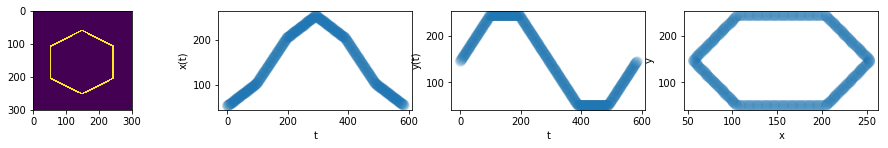

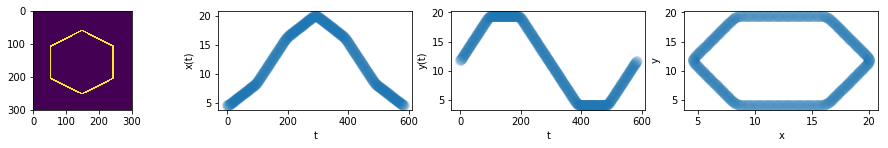

In [8]:
alpha = .1
size_scatter = 100    
plt.figure(figsize=(16,4))
plt.subplot(241)
plt.imshow(img)
plt.subplot(242)
plt.scatter(ts, positions[:,0], alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(243)
plt.scatter(ts, positions[:,1], alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.subplot(244)
plt.scatter(positions[:,0], positions[:,1], alpha=alpha, s=size_scatter)
plt.xlabel('x')
plt.ylabel('y')
plt.show()    


plt.figure(figsize=(16,4))
plt.subplot(245)
plt.imshow(img)
plt.subplot(246)
plt.scatter(ts,  smoothed_positions[:,0], alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(247)
plt.scatter(ts, smoothed_positions[:,1], alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.subplot(248)
plt.scatter( smoothed_positions[:,0],  smoothed_positions[:,1], alpha=alpha, s=size_scatter)
plt.xlabel('x')
plt.ylabel('y')
plt.show()   


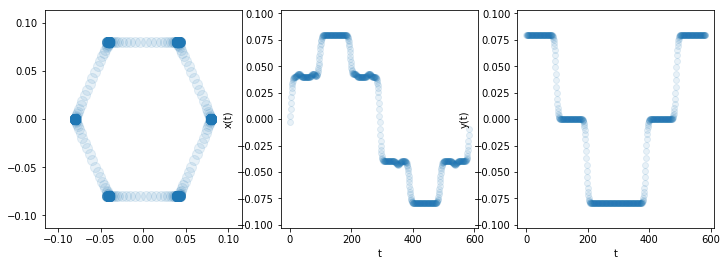

In [9]:
alpha = .1
size_scatter = 100
plt.clf()
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(d1s[:,0], d1s[:,1], alpha=alpha, s=size_scatter)

plt.subplot(132)
plt.scatter(ts, d1s[:,0], alpha=alpha)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(133)
plt.scatter(ts, d1s[:,1], alpha=alpha)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()


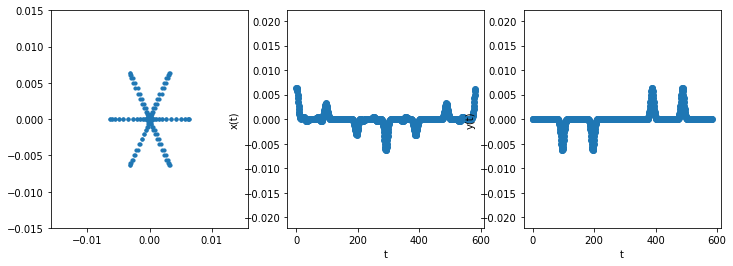

In [10]:
alpha = 1
size_scatter =10
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(d2s[:,0], d2s[:,1], alpha=alpha, s=size_scatter)
plt.subplot(132)
plt.scatter(ts, d2s[:,0], alpha=alpha)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(133)
plt.scatter(ts, d2s[:,1], alpha=alpha)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()



In [11]:
factor = .7
mod_ks, mod_ks_L,  max_ids = apply_threshold(ks, factor=factor)


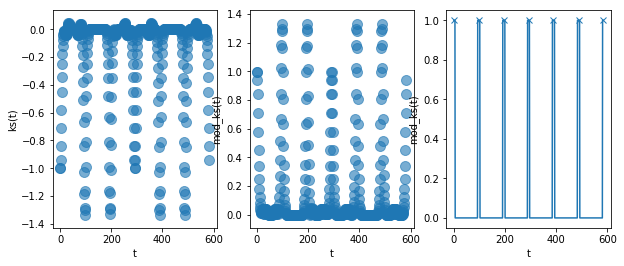

In [12]:



alpha = .6
size_scatter =100
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.scatter(ts, ks, alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('ks(t)')
plt.subplot(132)
plt.scatter(ts, mod_ks, alpha=alpha, s=size_scatter)
plt.xlabel('t')
plt.ylabel('mod_ks(t)')
plt.subplot(133)
plt.plot(ts, mod_ks_L,  '-x', markevery=max_ids)
plt.xlabel('t')
plt.ylabel('mod_ks(t)')
plt.show()



In [13]:
img_from_curvature = get_image_points_from_max_ids(positions, max_ids)

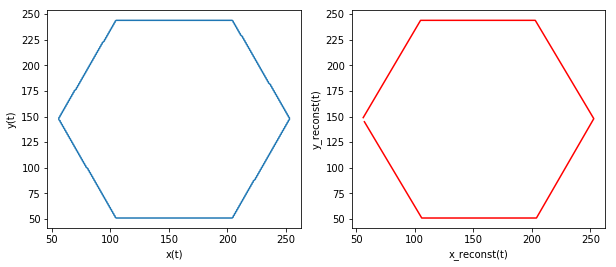

In [14]:




plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(positions[:,0], positions[:, 1])
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.subplot(122)
plt.plot(img_from_curvature[:,0], img_from_curvature[:,1], '-r')
plt.xlabel('x_reconst(t)')
plt.ylabel('y_reconst(t)')
plt.show()


## Gato

In [15]:
def cat_plot(sigma=2, factor=.45):

    alpha = .6
    size_scatter = 100

    img = imageio.imread("cat.gif").astype(np.uint8)
    positions = measure.find_contours(img, 0.2)[0]
    ts = range(len(positions))


    smoothed_positions, d1s, d2s, ks = get_smoothed_positions(positions, sigma=sigma)

    mod_ks, mod_ks_L,  max_ids = apply_threshold(ks, factor=factor)
    img_from_curvature = get_image_points_from_max_ids(positions, max_ids)

    print("\n\t Compressão")
    print("\t", (1- len(img_from_curvature)/len(positions))*100, "\n")


    plt.figure(figsize=(10,4))
    plt.subplot(131)
    plt.plot(positions[:,0], positions[:, 1])
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    plt.subplot(132)
    plt.scatter(img_from_curvature[:,0], img_from_curvature[:,1], alpha=alpha, s=size_scatter)
    plt.xlabel('x_reconst(t)')
    plt.ylabel('y_reconst(t)')
    plt.subplot(133)
    plt.plot(img_from_curvature[:,0], img_from_curvature[:,1], '-r')

    plt.show()


In [16]:
interactive_plot = interactive(
                                cat_plot,
                                sigma=(0.01,2, .05),
                                factor=(.01, 5, .05),
                              )

        
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='sigma', max=2.0, min=0.01, step=0.05), FloatSlider(value=0.45, description='factor', max=5.0, min=0.01, step=0.05), Output(layout=Layout(height='350px'))), _dom_classes=('widget-interact',))